## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
#Name: Justin Garzione
#NetID: justing6

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
import utils

# modify to where you store your project data including utils.py
datadir = "/Users/justingarzione/Documents/CompPhoto/PROJECT3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /Users/justingarzione/Documents/CompPhoto/PROJECT3/utils.py: No such file or directory


## Part 1 Toy Problem (20 pts)

In [201]:
def toy_reconstruct(im):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    # TO DO
    #Index to Vector Number
    im_h, im_w = im.shape
    
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    #Number of Equations (Y dimension of A and b)
    neq = (im_h * (im_w - 1)) + (im_w * (im_h - 1)) + 1
    
    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #-----
    e = 0
    
    #Vertical Constraints (Objective #2)
    for y in range(0,im_h-1):
        for x in range(0,im_w):
            A[e,im2var[y+1][x]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = im[y][x] - im[y+1][x]  
            e = e + 1
            
    #Horizontal Constraints (Objective #1)
    for y in range(0,im_h):
        for x in range(0,im_w-1):
            A[e,im2var[y][x+1]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = im[y][x] - im[y][x+1]
            e = e + 1

    #First Pixel Constraint (Objective #3)
    A[e,im2var[0][0]] = 1
    b[e] = im[0][0]
    e = e + 1
    
    #-----
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=0,btol=0); # solve w/ csr
    v2 = v[0].reshape(im_h,im_w)
    #A[i, j] = val   ### NOT A[i][j] = val
    return v2


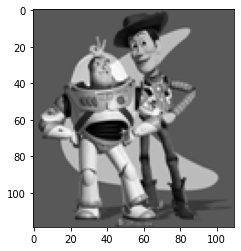

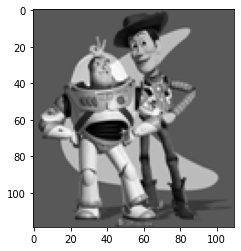

Max error is:  6.605826996519681e-14


In [202]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
#im_out = toy_img
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

In [5]:
  #xs = (65, 359, 359, 65)
  #ys = (24, 24, 457, 457)

## Preparation

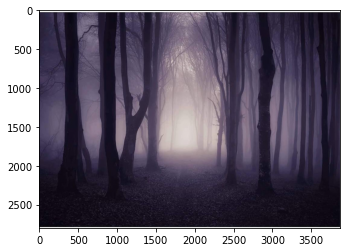

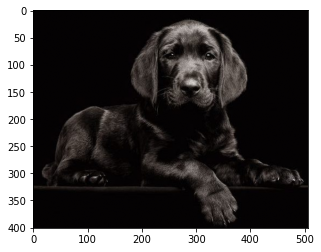

(378, 468, 3)


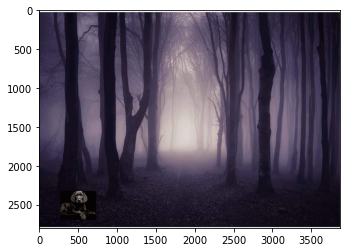

In [376]:
background_img = cv2.cvtColor(cv2.imread('samples/darkforest.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/dog.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (40, 650, 650, 40)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2700) # (x,y)
  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

object_mask[:,-1] = 0
object_mask[-1,:] = 0
print(object_img.shape)


In [367]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [368]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [369]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

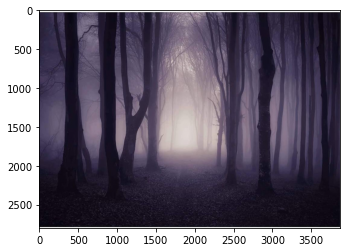

In [370]:
plt.imshow(background_img[:,:,:])

## Part 2 Poisson Blending (50 pts)

In [377]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    #Step 1: Sum the mask to get number of variables
    #Step 2:Traverse both dimensions of mask
        #if current pixel in mask is > zero
            #Look at up, down, left, right -> determine if those pixels are zero
                #if pixel in one of these pixels is = zero -> boundary constraint
                    #use constraint difference between i and j in object_img plus pixel in background
        #if not (meaning all surroundings are 1s)
            #Then *only* look right and down for constraints
                #Perform Toy Problem constraint on right and down
        #Solve the least squares
        #Reshape
        #take background image, go to point bg_ul and overwrite with the reshaped least squares solution
        
    #Object Shape
    im_h,im_w = object_mask.shape
    
    #Background upperleft coordinates
    bg_y, bg_x = bg_ul
    
    #Inner Dimensions
    smallh,smallw = (im_h-2,im_w-2)
    
    #Number of variables (Step 1)
    numVar = (object_mask>0).sum()

    #Number of Equations/Constraints = Inner Constraints + Outer Constraints
    neq = (smallh *(smallw-1) + smallw *(smallh-1)) + (2*(smallh+smallw))+1000000

    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, smallh*smallw), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #Build im2var
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(numVar)
    #print(im2var)
    
    e = 0
    #Step 2
    #Inner Constraints - Horizontal
    for y in range(0,im_h):
        for x in range(0,im_w-1):
            if object_mask[y,x] == 1:
                A[e,im2var[y][x+1]] = -1
                A[e,im2var[y][x]] = 1
                b[e] = object_img[y][x] - object_img[y][x+1]
                e = e + 1
            
    #Inner Constraints - Vertical
    for y in range(0,im_h-1):
        for x in range(0,im_w):
            if object_mask[y,x] == 1:
                A[e,im2var[y+1][x]] = -1
                A[e,im2var[y][x]] = 1
                b[e] = object_img[y][x] - object_img[y+1][x] 
                e = e + 1
            
    #Outer Constraints - Vertical North
    for x in range(0,im_w):
        y = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y-1][x]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y-1][x] 
            b[e] = b[e] + bg_img[bg_y+(y-1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Vertical South
    for x in range(0,im_w):
        y = im_h - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y+1][x]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y+1][x] 
            b[e] = b[e] + bg_img[bg_y+(y+1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Horizontal East
    for y in range(0,im_h):
        x = im_w - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x+1]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y][x+1] 
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x+1)]
            e = e + 1
    
    #Outer Constraints - Horizontal West
    for y in range(0,im_h):
        x = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x-1]] = -1
            A[e,im2var[y][x]] = 1
            b[e] = object_img[y][x] - object_img[y][x-1] 
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x-1)]
            e = e + 1
            
    #print(e)
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    v2 = v[0].reshape(smallh,smallw)
    #print(v2)
    #print(bg_img)
    #v2 = (v2 - np.min(v2)) / (np.max(v2)-np.min(v2))
    #plt.imshow(v2)
    output = bg_img
    for y in range(0,smallh):
        for x in range(0,smallw):
            output[bg_y+y][bg_x+x] = v2[y][x]
    
    #A[i, j] = val   ### NOT A[i][j] = val
    return output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


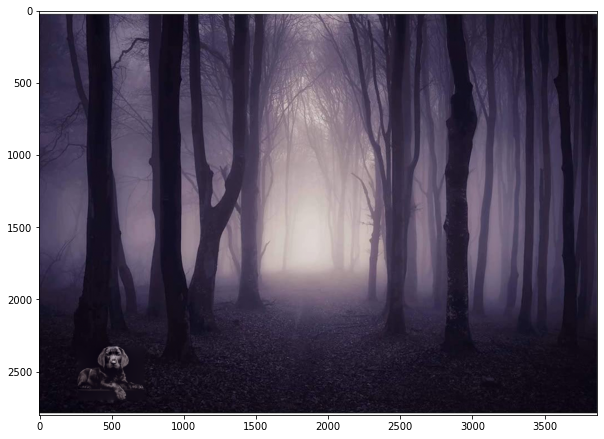

In [378]:
im_blend = np.zeros(background_img.shape)

for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)
plt.figure(figsize=(10,10))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

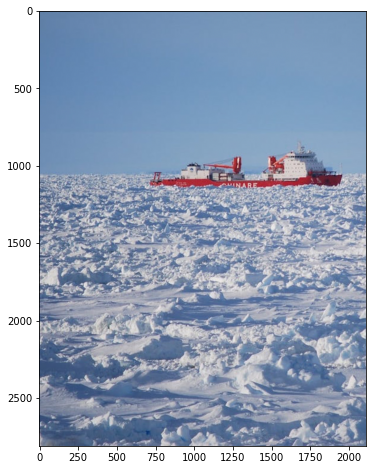

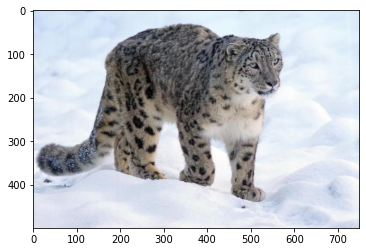

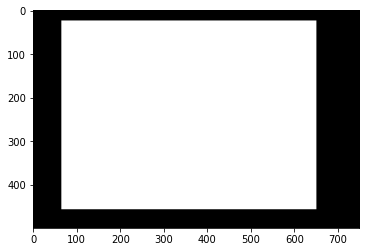

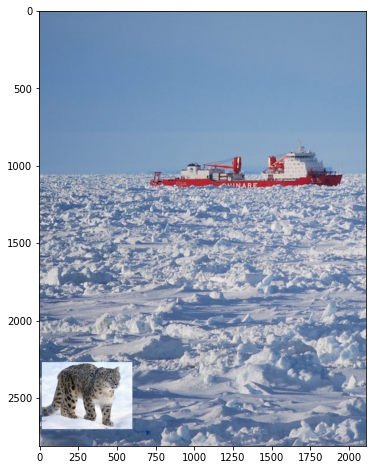

In [379]:
background_img = cv2.cvtColor(cv2.imread('samples/ice.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure(figsize=(8,8))
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/leopard.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()
use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
#if not use_interface:
xs = (65, 650, 650, 65)
ys = (24, 24, 457, 457)
#xs = (10, 600, 600, 10)
#ys = (24, 24, 457, 457)
object_mask = utils.get_mask(ys, xs, object_img)
bottom_center = (310, 2700) # (x,y)
object_img, object_mask = utils.crop_object_img(object_img, object_mask)
bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
plt.figure(figsize=(8,8))
plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

object_mask[:,-1] = 0
object_mask[-1,:] = 0

In [380]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    #Object Shape
    im_h,im_w = object_mask.shape
    
    #Background upperleft coordinates
    bg_y, bg_x = bg_ul
    
    #Inner Dimensions
    smallh,smallw = (im_h-2,im_w-2)
    
    #Number of variables (Step 1)
    numVar = (object_mask>0).sum()

    #Number of Equations/Constraints = Inner Constraints + Outer Constraints
    neq = (smallh *(smallw-1) + smallw *(smallh-1)) + (2*(smallh+smallw))+1000000

    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, smallh*smallw), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #Build im2var
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(numVar)
    #print(im2var)
    
    e = 0
    #Step 2
    #Inner Constraints - Horizontal
    for y in range(0,im_h):
        for x in range(0,im_w-1):
            if object_mask[y,x] == 1:
                A[e,im2var[y][x+1]] = -1
                A[e,im2var[y][x]] = 1
                a = object_img[y][x] - object_img[y][x+1]
                c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+y][bg_x+(x+1)]
                a1 = abs(a)
                c1 = abs(c)
                if a1 > c1:
                    b[e] = a
                else:
                    b[e] = c
                e = e + 1
            
    #Inner Constraints - Vertical
    for y in range(0,im_h-1):
        for x in range(0,im_w):
            if object_mask[y,x] == 1:
                A[e,im2var[y+1][x]] = -1
                A[e,im2var[y][x]] = 1
                a = object_img[y][x] - object_img[y+1][x]
                c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+(y+1)][bg_x+x]
                a1 = abs(a)
                c1 = abs(c)
                if a1 > c1:
                    b[e] = a
                else:
                    b[e] = c
                e = e + 1
            
    #Outer Constraints - Vertical North
    for x in range(0,im_w):
        y = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y-1][x]] = -1
            A[e,im2var[y][x]] = 1
            a = object_img[y][x] - object_img[y-1][x] 
            c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+(y-1)][bg_x+x]
            a1 = abs(a)
            c1 = abs(c)
            if a1 > c1:
                b[e] = a 
            else:
                b[e] = c
            b[e] = b[e] + bg_img[bg_y+(y-1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Vertical South
    for x in range(0,im_w):
        y = im_h - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y+1][x]] = -1
            A[e,im2var[y][x]] = 1
            a = object_img[y][x] - object_img[y+1][x]
            c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+(y+1)][bg_x+x]
            a1 = abs(a)
            c1 = abs(c)
            if a1 > c1:
                b[e] = a
            else:
                b[e] = c
            b[e] = b[e] + bg_img[bg_y+(y+1)][bg_x+x]
            e = e + 1
            
    #Outer Constraints - Horizontal East
    for y in range(0,im_h):
        x = im_w - 2
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x+1]] = -1
            A[e,im2var[y][x]] = 1
            a = object_img[y][x] - object_img[y][x+1] 
            c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+y][bg_x+(x+1)]
            a1 = abs(a)
            c1 = abs(c)
            if a1 > c1:
                b[e] = a
            else:
                b[e] = c
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x+1)]
            e = e + 1
    
    #Outer Constraints - Horizontal West
    for y in range(0,im_h):
        x = 1
        if object_mask[y,x] == 1:
            #A[e,im2var[y][x-1]] = -1
            A[e,im2var[y][x]] = 1
            a = object_img[y][x] - object_img[y][x-1] 
            c = bg_img[bg_y+y][bg_x+x] - bg_img[bg_y+y][bg_x+(x-1)]
            a1 = abs(a)
            c1 = abs(c)
            if a1 > c1:
                b[e] = a
            else:
                b[e] = c
            b[e] = b[e] + bg_img[bg_y+y][bg_x+(x-1)]
            e = e + 1
            
    #print(e)
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    v2 = v[0].reshape(smallh,smallw)
    #print(v2)
    #print(bg_img)
    #v2 = (v2 - np.min(v2)) / (np.max(v2)-np.min(v2))
    #plt.imshow(v2)
    output = bg_img
    for y in range(0,smallh):
        for x in range(0,smallw):
            output[bg_y+y][bg_x+x] = v2[y][x]
    
    #A[i, j] = val   ### NOT A[i][j] = val
    return output

    



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


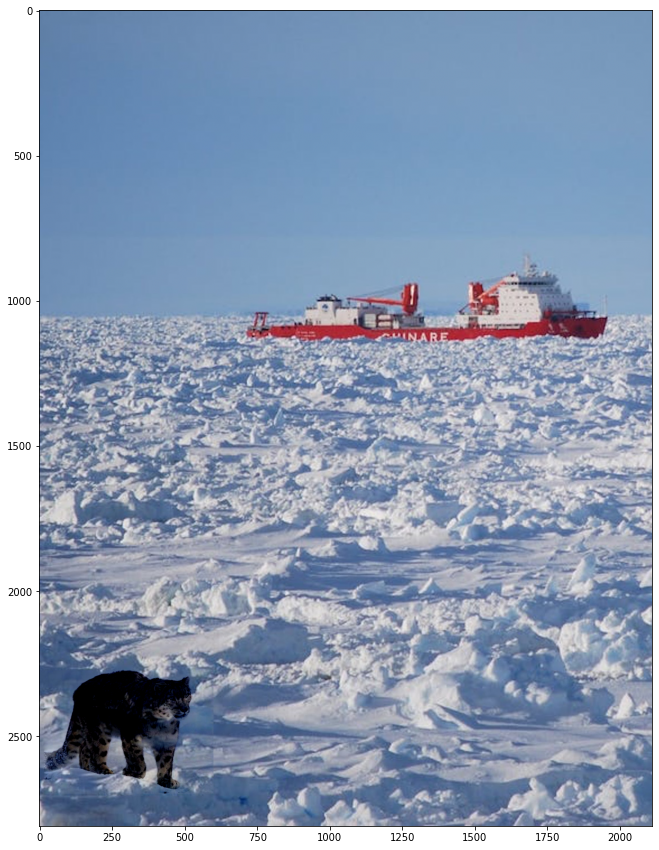

In [381]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [15]:
def color2gray(im):
    # TO DO
    #Index to Vector Number
    im_h, im_w, im_z = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    output = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
    
    #neq = ((((im_w-1)*(im_h-1))-1)*2)+(im_w)+(im_h)+1
    
    #Number of Equations (Y dimension of A and b)
    neq = im_h * (im_w - 1) + im_w * (im_h - 1) + 1
    
    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #-----
    #First Pixel Constraint (Objective #3)
    e = 0
    A[e][im2var[0][0]] = 1
    b[e] = im[0][0][1]
    e = e + 1
    
    #Vertical Constraints (Objective #2)
    for y in range(1,im_h-1):
        for x in range(0,im_w):
            A[e,im2var[y+1][x]] = 1
            A[e,im2var[y][x]] = -1
            z1 = im[y+1][x][0] - im[y][x][0]
            z2 = im[y+1][x][1] - im[y][x][1]
            z3 = im[y+1][x][2] - im[y][x][2]
            z1a = abs(z1)
            z2a = abs(z2)
            z3a = abs(z3)
            if max(z1a,z2a,z3a) == z1a: b[e] = z1
            elif max(z1a,z2a,z3a) == z2a: b[e] = z2
            elif max(z1a,z2a,z3a) == z3a: b[e] = z3
            #b[e] = (z1 + z2 + z3)/3
            e = e + 1
            
    #Horizontal Constraints (Objective #1)
    for y in range(0,im_h):
        for x in range(1,im_w-1):
            A[e,im2var[y][x+1]] = 1
            A[e,im2var[y][x]] = -1
            z1 = im[y][x+1][0] - im[y][x][0]
            z2 = im[y][x+1][1] - im[y][x][1]
            z3 = im[y][x+1][2] - im[y][x][2]
            z1a = abs(z1)
            z2a = abs(z2)
            z3a = abs(z3)
            if max(z1a,z2a,z3a) == z1a: b[e] = z1
            elif max(z1a,z2a,z3a) == z2a: b[e] = z2
            elif max(z1a,z2a,z3a) == z3a: b[e] = z3
            #b[e] = (z1 + z2 + z3) /3
            e = e + 1
            
    #-----
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b); # solve w/ csr
    v2 = v[0].reshape(im_h,im_w)
    #A[i, j] = val   ### NOT A[i][j] = val
    return v2

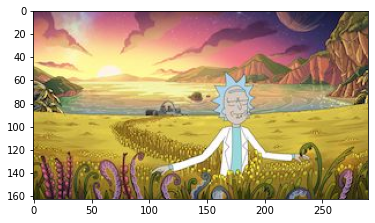

In [227]:
cbimg = cv2.cvtColor(cv2.imread('samples/rick.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
output = color2gray(cbimg)

plt.imshow(cbimg)#, cmap ="gray")

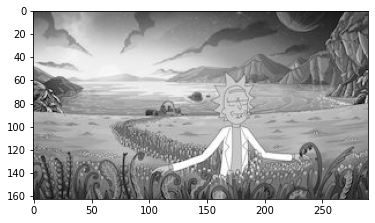

In [226]:
cbimg1 = cv2.cvtColor(cv2.imread('samples/rick.jpg'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(cbimg1, cmap="gray")

## Laplacian pyramid blending (20 pts)

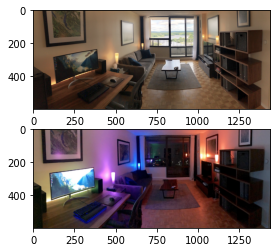

In [18]:
fig, axes = plt.subplots(2,1)
im1_file = datadir + 'samples/roomimg1.png'
im1 = cv2.cvtColor(cv2.imread(im1_file), cv2.COLOR_BGR2RGB).astype('double') / 255.0
im2_file = datadir + 'samples/roomimg2.png'
im2 = cv2.cvtColor(cv2.imread(im2_file), cv2.COLOR_BGR2RGB).astype('double') / 255.0

axes[0].imshow(im1)
#axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2)
#axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([])


In [19]:
def laplacian_blend(im1, im2, sigma):
    
    #Build Mask
    l,w = im1.shape
    image_mask = np.zeros(im1.shape)
    image_mask[:,0:(round(w/2))] = 1
    
    def blur(image1,sigma):
        ksize1 = np.int(np.ceil(sigma)*6+1)
        fil = cv2.getGaussianKernel(ksize1, sigma)
        fil = fil*np.transpose(fil)
        im1 = cv2.filter2D(image1,-1,fil)
        return (im1)
    
    def subsamp(imagee):
        imagee = cv2.resize(imagee, (0,0), fx=0.5,fy=0.5)
        return imagee
    
    def sampleImage(im,sigma):
        new_im = blur(im,sigma)
        new_im = subsamp(new_im)
        return(new_im)
    
    def upsamp(imm):
        imm = cv2.resize(imm, (0,0), fx=2.0,fy=2.0)
        return imm
    
    #Level 1 Images
    a0 = im1 - blur(im1,sigma)
    b0 = im2 - blur(im2,sigma)
    m0 = blur(image_mask,10)
    
    output0 = (a0 * m0) + (b0*(1-m0))
    #Level 2 Images
    a1 = sampleImage(im1,sigma)
    b1 = sampleImage(im2,sigma)
    m1 = sampleImage(image_mask,sigma)
    
    output1 = (a1 * m1) + (b1*(1-m1))
    output1 = upsamp(output1)
    #print(output1.shape)
    result = output1 + output0
    
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


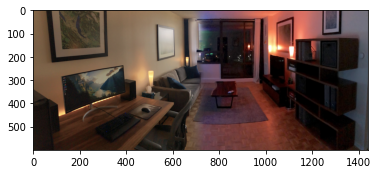

In [26]:
output = np.zeros(im1.shape)
for q in np.arange(3):
  output[:,:,q] = laplacian_blend(im1[:,:,q], im2[:,:,q],20)
plt.imshow(output)


## More gradient domain processing (up to 20 pts)

In [307]:
def rendering(im):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    #im = cv2.cvtColor(cv2.imread(im1), cv2.COLOR_BGR2RGB).astype('double') / 255.0
    # TO DO
    #Index to Vector Number
    im_h, im_w = im.shape
    
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    #Number of Equations (Y dimension of A and b)
    neq = (im_h * (im_w - 1)) + (im_w * (im_h - 1)) + 1
    
    #Build Sparse Matrix with correct dimensions
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    
    #Build Vector B
    b = np.zeros((neq,1), dtype='double')
    
    #-----
    e = 0
    
    #Vertical Constraints (Objective #2)
    for y in range(0,im_h-1):
        for x in range(0,im_w):
            A[e,im2var[y+1][x]] = -1
            A[e,im2var[y][x]] = 1
            a = im[y][x] - im[y+1][x]
            b[e] = a
            e = e + 1
            
    #Horizontal Constraints (Objective #1)
    #for y in range(0,im_h):
    for x in range(0,im_w-1):
            A[e,im2var[y][x+1]] = -1
            A[e,im2var[y][x]] = 1
            a = im[y][x] - im[y][x+1]
            b[e] = a
            e = e + 1

    #First Pixel Constraint (Objective #3)
    A[e,im2var[0][0]] = 1
    b[e] = im[0][0]
    e = e + 1
    
    #-----
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=0,btol=0); # solve w/ csr
    v2 = v[0].reshape(im_h,im_w)
    #A[i, j] = val   ### NOT A[i][j] = val
    return v2

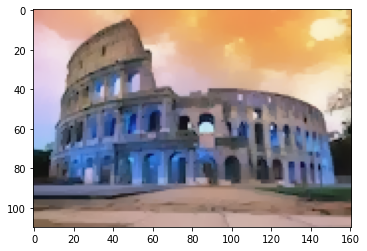

In [316]:
convertedimg = cv2.cvtColor(cv2.imread('samples/rome.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
image = cv2.imread("samples/rome.jpg");
style0 = cv2.stylization(image, sigma_s=60, sigma_r=0.07)
style1 = cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)
style2 = cv2.edgePreservingFilter(image, flags=1, sigma_s=60, sigma_r=0.4)
plt.imshow(style2)
plt.show()